<a href="https://colab.research.google.com/github/juhumkwon/source_code/blob/main/VAE(10%EC%9B%94_7%EC%9D%BC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.4256 - val_loss: 0.3285
Epoch 2/2
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3230 - val_loss: 0.3135


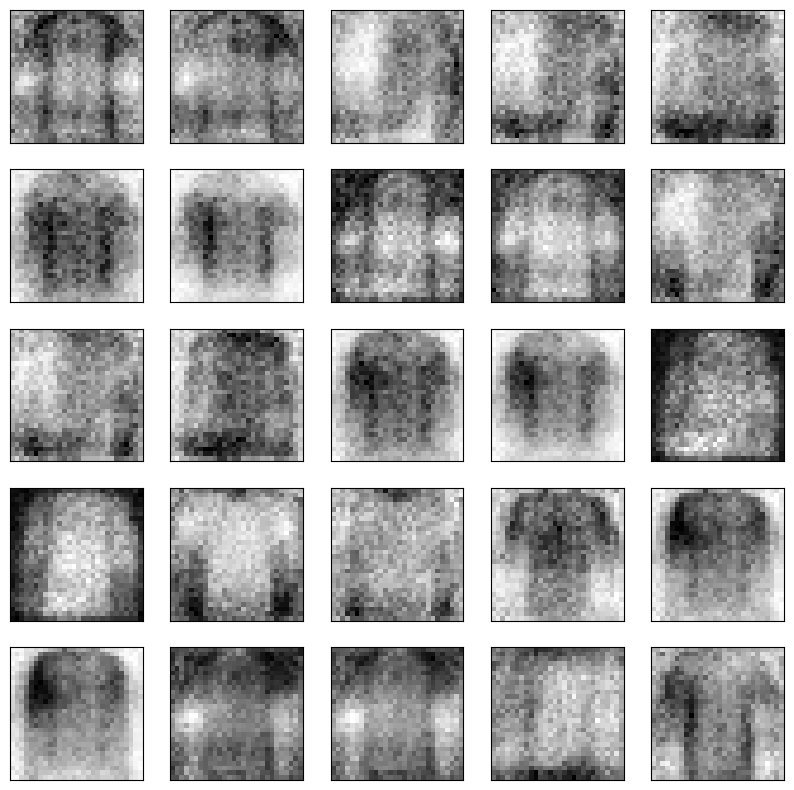

In [18]:
#출처: https://www.jeremyjordan.me/variational-autoencoders/

# μ와 γ가 주어졌을 때 코딩을 샘플링하는 사용자 정의 층
from tensorflow import keras
import tensorflow as tf # import tensorflow

# backend는 이러한 백엔드와 관련된 저수준의 연산을 다루기 위한 모듈
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

# 함수형 API를 통해 인코더 생성
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# 디코더 생성
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# 변이형 오토인코더 모델 생성
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# 잠재 손실과 재구성 손실을 추가
class VariationalLossLayer(keras.layers.Layer):
    def call(self, inputs):
        codings_mean, codings_log_var = inputs
        latent_loss = -0.5 * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1)
        # This layer only calculates the loss, no output is needed
        self.add_loss(K.mean(latent_loss) / 784.)
        return inputs  # Pass through the inputs unchanged

# ... (rest of the code for variational_ae) ...

# Create an instance of the custom loss layer
loss_layer = VariationalLossLayer()
# Connect the layer to the outputs of the encoder
codings_mean, codings_log_var, codings = variational_encoder(inputs)
# Pass codings_mean and codings_log_var through the loss layer
loss_layer([codings_mean, codings_log_var])

reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# Remove the previous add_loss line as the custom layer handles it
# variational_ae.add_loss(K.mean(latent_loss) / 784.)

variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")


# 오토인코더 훈련
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Create a validation set from the training data
# For example, use the first 10,000 samples as validation data
X_valid, X_train = X_train[:10000], X_train[10000:]

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_valid = X_valid / 255.0
test_images = test_images / 255.0

# 오토인코더 훈련
#history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
history = variational_ae.fit(X_train, X_train, epochs=2, batch_size=128,
                             validation_data=(X_valid, X_valid))

# 이미지 생성
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]) #plt.xticks([])는 Matplotlib에서 x축의 눈금을 숨기는 함수입니다.
    plt.yticks([]) #Matplotlib에서 y축의 눈금을 숨기는 함수입니다.
    plt.grid(False) #Matplotlib에서 그래프의 격자(grid)를 비활성화하는 함수입니다.
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()
